In [1]:
import os
import torch
import time
import logging
from pyinstrument import Profiler
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR

import sys
sys.path.insert(0, '/home/rosewt/Documentos/codigos2024/SordoMudos/src/')

import models.CNN.model as model


In [2]:

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(
    filename="../logs/train.log",  # Nombre del archivo de log
    filemode="a",  # Modo de apertura en append para no sobrescribir
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)

In [3]:

sys.path.insert(0, '/home/rosewt/Documentos/codigos2024/SordoMudos/')
import src.preprocessing.data_processing as dp

try:
    data_directory = '../../data/raw/Static-Hand-Gestures-of-the-Peruvian-Sign-Language-Alphabet'
    data_output = '../../data/processed/split'

    imgs_train, imgs_test, labels_train, labels_test,\
          imgs_val, label_val, label_to_index = dp.process_imgs(
              data_directory, method='canny', data_output = data_output
              )
    
    logging.info("Ejecución completa. Datos listos para uso.")
    print("Proceso completado. Datos listos para uso.")
except Exception as e:
    print(e)
    logging.error(f"Error durante la ejecución principal: {e}")
    print("Hubo un error durante el procesamiento. Revisa el log para más detalles.")

Proceso completado. Datos listos para uso.


In [4]:
def log_time(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        logging.info(f"{func.__name__}: {end_time - start_time:.2f} segundos")
        return result
    return wrapper


In [5]:
import torch
import torch.nn.functional as F


def process_X(X):
    X = torch.tensor(X, dtype=torch.float32)
    if X.dim() == 3:
        X = X.unsqueeze(1)
    elif X.dim() == 4:
        X = X.permute(0, 3, 1, 2)
    else:
        raise ValueError(f"Dimensión de X no soportada: {X.shape}")
    return X

@log_time
def convert_to_tensors(X_train, X_val, y_train, y_val):
    X_train = process_X(X_train)
    X_val = process_X(X_val)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_val = torch.tensor(y_val, dtype=torch.long)
    
    # Normalizar las imágenes
    X_train = X_train / 255.0
    X_val = X_val / 255.0
    
    # Redimensionar las imágenes al tamaño esperado por el modelo
    X_train = F.interpolate(X_train, size=(224, 224), mode='bilinear', align_corners=False)
    X_val = F.interpolate(X_val, size=(224, 224), mode='bilinear', align_corners=False)
    
    # Imprimir formas para depuración
    print(f"Forma de X_train: {X_train.shape}")
    print(f"Forma de y_train: {y_train.shape}")
    print(f"Forma de X_val: {X_val.shape}")
    print(f"Forma de y_val: {y_val.shape}")
    
    return X_train, X_val, y_train, y_val


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

def create_dataloaders(X_train, y_train, X_val, y_val, batch_size=32, num_workers=4, pin_memory=False, prefetch_factor=2):
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory,
        prefetch_factor=prefetch_factor,
        persistent_workers=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    
    return train_loader, val_loader

In [7]:
# Directorio de datos

data_directory = os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'datasets', 'Static-Hand-Gestures-of-the-Peruvian-Sign-Language-Alphabet'))
print("Ruta de datos:", data_directory)


#Cargar y procesar los datos
X_train, X_val, y_train, y_val, label_mapping = imgs_train, imgs_val, labels_train, label_val, label_to_index 

# Convertir los datos a tensores
X_train, X_val, y_train, y_val = convert_to_tensors(X_train, X_val, y_train, y_val)

# Información sobre el conjunto de datos
logging.info(f"Tamaño de conjunto de entrenamiento: {len(X_train)}")
logging.info(f"Tamaño de conjunto de validación: {len(X_val)}")
logging.info(f"Diccionario de etiquetas: {label_mapping}")


Ruta de datos: /home/rosewt/Documentos/codigos2024/SordoMudos/datasets/Static-Hand-Gestures-of-the-Peruvian-Sign-Language-Alphabet
Forma de X_train: torch.Size([2304, 1, 224, 224])
Forma de y_train: torch.Size([2304])
Forma de X_val: torch.Size([576, 1, 224, 224])
Forma de y_val: torch.Size([576])


/tmp/ipykernel_15667/1641893257.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  X = torch.tensor(X, dtype=torch.float32)


In [ ]:
# Crear los DataLoaders

batch_size=64
num_workers=4
pin_memory=True
prefetch_factor=1


train_loader, val_loader = create_dataloaders(
    X_train,y_train, X_val, y_val,\
    batch_size=batch_size, num_workers=num_workers, \
    pin_memory=pin_memory, prefetch_factor=prefetch_factor)

# Información sobre los DataLoaders
logging.info(f"Parametros de DataLoader: batch_size={batch_size}, num_workers={num_workers}, pin_memory={pin_memory}, prefetch_factor={prefetch_factor}")

logging.info(f"Tamaño de DataLoader de entrenamiento: {len(train_loader)}")
logging.info(f"Tamaño de DataLoader de validación: {len(val_loader)}")



In [9]:
# Selección de modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(label_mapping)

name_model = 'rustic'

model = model.RusticModel(num_classes).to(device)

# Alternativa: model = ViTModel(num_classes).to(device)

# Configuración del optimizador, función de pérdida y scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


In [10]:
# Ciclo de entrenamiento


# Inicializar listas para almacenar las métricas
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
epoch_times = []


num_epochs = 24
for epoch in range(num_epochs):
    model.train()  # Modo entrenamiento
    start_time = time.time()
    logging.info(f"--- Inicio de la Época {epoch + 1}/{num_epochs} ---")


    total_loss = 0
    total_correct = 0

    try:
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass y optimización
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == labels).sum().item()
        
        scheduler.step()
        
        # Precisión en el conjunto de entrenamiento
        train_accuracy = total_correct / len(train_loader.dataset)

        train_losses.append(total_loss/ len(train_loader))
        train_accuracies.append(train_accuracy)

        logging.info(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}, Accuracy: {train_accuracy:.4f}")

        # Validación del modelo
        model.eval()
        val_loss = 0
        val_correct = 0
        with torch.no_grad(): 
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = val_correct / len(val_loader.dataset)

        val_losses.append(val_loss/ len(val_loader))
        val_accuracies.append(val_accuracy)

        logging.info(f"Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}")
    except Exception as e:
        logging.exception(f"Error durante el entrenamiento: {e}")
        break
    end_time = time.time()
    elapsed_time = end_time - start_time
    epoch_times.append(elapsed_time)
    logging.info(f"Tiempo total de la época {epoch + 1}: {elapsed_time:.2f} segundos\n")

logging.info("Entrenamiento finalizado")


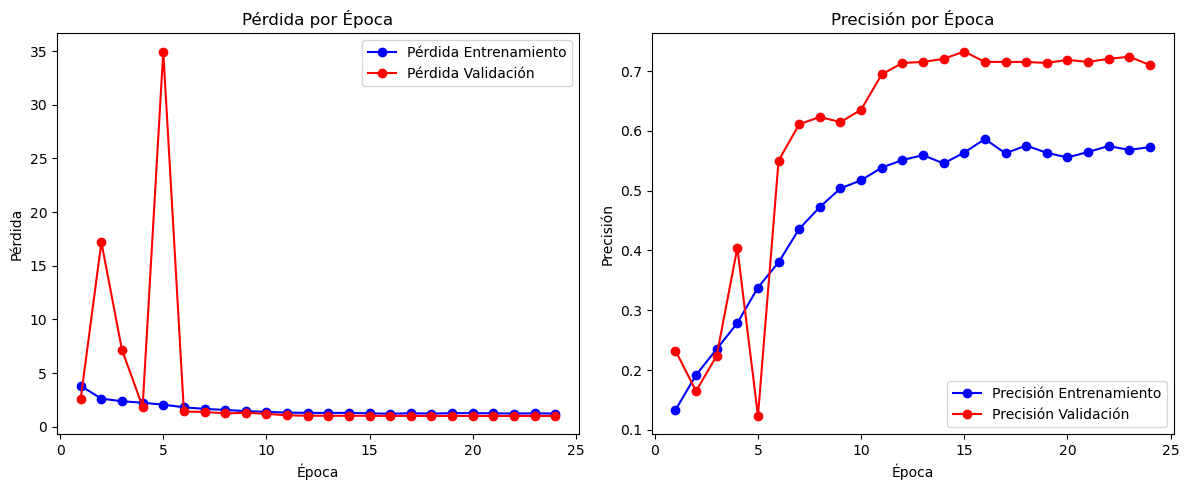

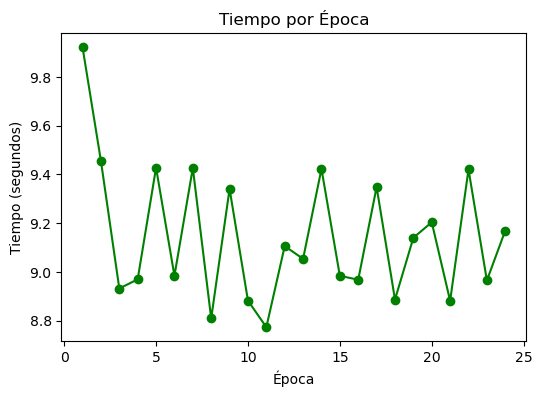

In [11]:
import matplotlib.pyplot as plt

def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, epoch_times):
    epochs = range(1, len(train_losses) + 1)
    
    # Pérdida
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, 'bo-', label='Pérdida Entrenamiento')
    plt.plot(epochs, val_losses, 'ro-', label='Pérdida Validación')
    plt.title('Pérdida por Época')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    
    # Precisión
    plt.subplot(1,2,2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Precisión Entrenamiento')
    plt.plot(epochs, val_accuracies, 'ro-', label='Precisión Validación')
    plt.title('Precisión por Época')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Tiempo por Época
    plt.figure(figsize=(6,4))
    plt.plot(epochs, epoch_times, 'go-')
    plt.title('Tiempo por Época')
    plt.xlabel('Época')
    plt.ylabel('Tiempo (segundos)')
    plt.show()

# Llamar a la función después del ciclo de entrenamiento
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, epoch_times)

In [12]:
# Guardar el modelo entrenado
model_path = f"{name_model}.pth"
model_path = os.path.join("../models/CNN", model_path)
torch.save(model.state_dict(), model_path)
logging.info(f"Modelo guardado exitosamente en {model_path}")
